## Survival Support Vector Machine

Can account for complex, non-linear relationships between features and survival via the so-called kernel. It implicitly maps the input features into high-dimensional feature spaces where survival can be described by a hyperplane. It makes Survival Support Vector Machines extremly versatile and applicable to a wide range of data.

We will be using the **Radial Basis Function**

In the case of survival analysis, SVM can be used for:

- Classification: the model learns to assign/class samples with shorter survival times a class by considering all possible pairs of samples.
- Regression: the model learns to directly predict the (log) survival time.

## Linear Survival Support Vector Machine.

It does not allow a specific kernel function, but it can be fitted faster than the generic Kernel Survival Support Vector Machine. Choosing a specific kernel for the job is a long task and requires extra time.

We use the GridSearchCV to determine the best setting for the hyper-parameter alpha which determines the amount of regularization to apply to the regression objective.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas
import seaborn as sns
from sklearn import set_config
from sklearn.model_selection import GridSearchCV, ShuffleSplit

from sksurv.column import encode_categorical
from sksurv.datasets import load_veterans_lung_cancer
from sksurv.metrics import concordance_index_censored
from sksurv.svm import FastSurvivalSVM

set_config(display="text")  # displays text representation of estimators
sns.set_style("whitegrid")

In [4]:
data_x, y = load_veterans_lung_cancer()
x = encode_categorical(data_x)

In [5]:
n_censored = y.shape[0] - y["Status"].sum()
print(f"{n_censored / y.shape[0] * 100:.1f}% of records are censored")

6.6% of records are censored


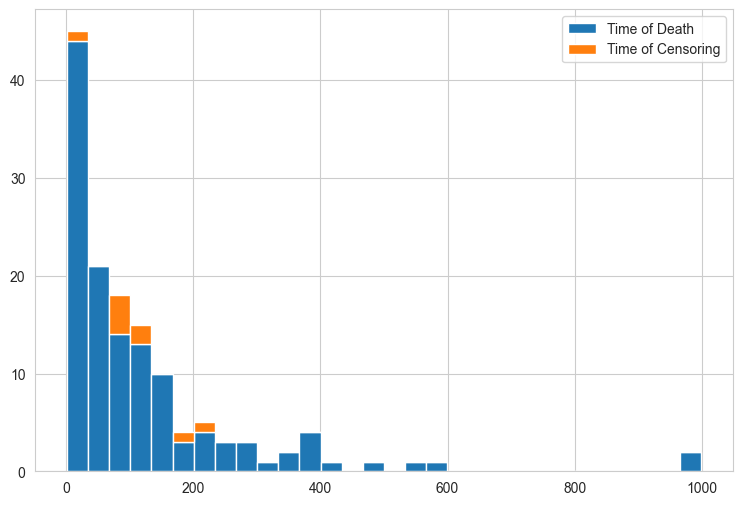

In [6]:
plt.figure(figsize=(9, 6))
val, bins, patches = plt.hist(
    (y["Survival_in_days"][y["Status"]], y["Survival_in_days"][~y["Status"]]), bins=30, stacked=True
)
_ = plt.legend(patches, ["Time of Death", "Time of Censoring"])

First, we need to create an initial model with default parameters that is subsequently used in the grid search.

In [7]:
estimator = FastSurvivalSVM(max_iter=1000, tol=1e-5, random_state=0)

Next, we define a function for evaluating the performance of models during grid search. We use Harrell's concordance index (also known as concordance index).

In [8]:
def score_survival_model(model, X, y):
    prediction = model.predict(X)
    result = concordance_index_censored(y["Status"], y["Survival_in_days"], prediction)
    return result[0]